# PyTorch Enhancement Notebook

__Design & Develop:__ Mobin Nesari

## Import Required Libraries
This code cell imports various modules and functions that will be used in the notebook. Here's a breakdown of each import:

- `torch`: The main PyTorch library, which provides the core functionality for deep learning.
- `nn`: The neural networks module in PyTorch, which contains classes for building various types of neural networks.
- `torch.nn.functional as F`: The functional form of PyTorch's neural network module, which provides a set of functions for building neural networks.
- `matplotlib.pyplot as plt`: The plotting library for creating visualizations.
- `torch.utils.data`: The data loading and manipulation module in PyTorch.
- `random_split`: A function from the torch.utils.data module for splitting datasets into random subsets.
- `torchvision.datasets`: The dataset loading module in torchvision, which provides pre-built datasets for computer vision tasks.
- `torchvision.transforms`: The data transformation module in torchvision, which provides functions for transforming input data.

In [4]:
import torch 
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision import transforms
from copy import deepcopy
import torch.optim as optim

from tqdm.notebook import tqdm 
import numpy as np

## Gradient Descent
Gradient Descent is a popular optimization algorithm used to find the minimum of a function. It works by taking small steps proportional to the negative gradient of the function. Here's a basic implementation:
$$\theta_j := \theta_j - \alpha \frac{\partial J(\theta_0, \theta_1, ..., \theta_n)}{\partial \theta_j}$$

In [2]:
def gradient_descent(x, y, theta, alpha, num_iters):
    m = len(y)
    for i in range(num_iters):
        h = np.dot(x, theta)
        loss = h - y
        gradient = np.dot(x.T, loss) / m
        theta -= alpha * gradient
    return theta

## Stochastic Gradient Descent
Stochastic Gradient Descent is a variation of Gradient Descent that randomly selects a subset of the training data to compute the gradient. This can be more efficient for large datasets. Here's a basic implementation:

\begin{equation*}

w_{t+1} = w_t - \eta \nabla f_i(w_t)

\end{equation*}

In [3]:
def stochastic_gradient_descent(x, y, theta, alpha, num_epochs, batch_size):
    m = len(y)
    num_batches = m // batch_size
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = (batch + 1) * batch_size
            batch_x = x[start_idx:end_idx]
            batch_y = y[start_idx:end_idx]
            h = np.dot(batch_x, theta)
            loss = h - batch_y
            gradient = np.dot(batch_x.T, loss) / batch_size
            theta -= alpha * gradient
    return theta

## Adam
Adam is an adaptive learning rate optimization algorithm commonly used in deep learning. It combines ideas from both Adagrad and RMSProp. Here's a basic implementation:

\begin{align*}

m_{t+1} &= \beta_1 m_t + (1 - \beta_1) g_t \\

v_{t+1} &= \beta_2 v_t + (1 - \beta_2) g_t^2 \\

\hat{m}_{t+1} &= \frac{m_{t+1}}{1 - \beta_1^{t+1}} \\

\hat{v}_{t+1} &= \frac{v_{t+1}}{1 - \beta_2^{t+1}} \\

w_{t+1} &= w_t - \eta \frac{\hat{m}_{t+1}}{\sqrt{\hat{v}_{t+1}} + \epsilon}

\end{align*}

In [4]:
def adam(x, y, theta, alpha, beta1, beta2, eps, num_iters):
    m = len(y)
    mo = np.zeros(theta.shape)
    v = np.zeros(theta.shape)
    for i in range(num_iters):
        h = np.dot(x, theta)
        loss = h - y
        gradient = np.dot(x.T, loss) / m
        mo = beta1 * mo + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)
        mo_corrected = mo / (1 - beta1 ** (i + 1))
        v_corrected = v / (1 - beta2 ** (i + 1))
        theta -= alpha * mo_corrected / (np.sqrt(v_corrected) + eps)
    return theta

## The Dataset
### MNIST Dataset
The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing machine learning models, particularly in the field of image recognition. The dataset consists of 70,000 grayscale images of handwritten digits from 0 to 9, with each image being a 28x28 pixel square (784 pixels in total).

#### Key Features of the MNIST Dataset:
- *Image Size*: Each image in the dataset is 28x28 pixels, making it a small and manageable dataset for training and testing purposes.
- *Labeling*: Each image is associated with a label indicating the digit it represents (0 to 9).
- *Training and Testing Sets*: The dataset is typically divided into a training set of 60,000 images and a testing set of 10,000 images, allowing researchers to evaluate the performance of their models.
- *Standard Benchmark*: The MNIST dataset has become a standard benchmark for evaluating the performance of machine learning algorithms, particularly in the field of image classification.
#### Applications of the MNIST Dataset:
- *Digit Recognition*: The dataset is commonly used for training models to recognize handwritten digits, making it a foundational dataset for digit recognition tasks.
- *Benchmarking Algorithms*: Researchers often use the MNIST dataset to compare the performance of different machine learning algorithms and techniques in image classification tasks.
- *Educational Purposes*: Due to its simplicity and accessibility, the MNIST dataset is frequently used in educational settings to introduce students to image classification and machine learning concepts.

The MNIST dataset serves as a fundamental resource for researchers, students, and machine learning enthusiasts to develop, test, and benchmark image recognition algorithms.

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='./MNIST', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='./MNIST', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Simple Model Implementation

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Gradient Descent

Gradient Descent is an optimization algorithm that updates the weights by taking small steps proportional to the negative gradient of the cost function. Here's an implementation:

In [7]:
net_sgd = Net()
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(net_sgd.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_sgd.zero_grad()
        outputs = net_sgd(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Training loss: {running_loss/len(trainloader)}")

Epoch 1 - Training loss: 0.751909927486865
Epoch 2 - Training loss: 0.36919543051770504
Epoch 3 - Training loss: 0.32457284221072186
Epoch 4 - Training loss: 0.2984010190693046
Epoch 5 - Training loss: 0.2784049235014265
Epoch 6 - Training loss: 0.2595501922245727
Epoch 7 - Training loss: 0.24275317413212139
Epoch 8 - Training loss: 0.2260771152466091
Epoch 9 - Training loss: 0.21193756982842996
Epoch 10 - Training loss: 0.19857726572577888


## Adam

Adam is an optimization algorithm that uses a combination of the momentum and the RMSProp algorithms to update the weights. Here's an implementation:

In [8]:
net_adam = Net()
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(net_adam.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_adam.zero_grad()
        outputs = net_adam(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Training loss: {running_loss/len(trainloader)}")

Epoch 1 - Training loss: 0.39829621126434445
Epoch 2 - Training loss: 0.27143309249091885
Epoch 3 - Training loss: 0.2526377979944001
Epoch 4 - Training loss: 0.24488185862027634
Epoch 5 - Training loss: 0.23214142563254403
Epoch 6 - Training loss: 0.22182837139362338
Epoch 7 - Training loss: 0.2308436732129581
Epoch 8 - Training loss: 0.2201322489011008
Epoch 9 - Training loss: 0.22064448215329507
Epoch 10 - Training loss: 0.22146882209231827


### Comparing the Results
Now that we've trained our neural network using these four optimization algorithms, let's compare their performance on the test set:

In [9]:
def evaluate(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

print(f"Accuracy (SGD): {evaluate(net_sgd, testloader)}")
print(f"Accuracy (Adam): {evaluate(net_adam, testloader)}")

Accuracy (SGD): 0.9436
Accuracy (Adam): 0.9389


## Transformation

### Transformations in PyTorch
PyTorch provides a wide range of transformations that can be applied to images or other data. Here are some commonly used transformations:

### *Resize*
The `transforms.Resize` transformation resizes an image to a specified height and width. The formula for resizing an image is:

$$\text{Resized Image} = \text{Resize}(Image, Height, Width)$$

### *Random Rotation*
The `transforms.RandomRotation` transformation randomly rotates an image by a specified angle. The formula for rotating an image is:

$$\text{Rotated Image} = \text{Rotate}(Image, Angle)$$

### *Normalization*
The `transforms.Normalize` transformation normalizes the pixel values of an image to a specified mean and standard deviation. The formula for normalizing an image is:

$$\text{Normalized Image} = \frac{\text{Image} - \text{Mean}}{\text{Standard Deviation}}{\text{Standard Deviation}}$$

### *Padding*
The `transforms.Pad` transformation pads an image with a specified amount of padding on all sides. The formula for padding an image is:

$$\text{Padded Image} = \text{Pad}(Image, Padding)$$

### *Lambda Transformation*
The `transforms.Lambda` transformation applies a custom lambda function to an image. The formula for applying a lambda function to an image is:

$$\text{Transformed Image} = \lambda(Image)$$

These transformations can be combined and applied to datasets using the `torchvision.transforms` module in PyTorch.

In [6]:
transformation = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomRotation(90), 
    transforms.ToTensor(),
])

## Dataset 

<img src="https://cdn.shortpixel.ai/spai/q_lossy+w_806+to_webp+ret_img/algotrading101.com/learn/wp-content/uploads/2020/06/training-validation-test-data-set.png" alt="Train validation test split" width="600" height="300">

### Cross Validation
Cross-validation is a technique used in machine learning to assess the performance and generalization of a predictive model. It involves splitting the dataset into multiple subsets, training the model on a subset of the data, and evaluating it on the remaining subset. Cross-validation helps to estimate how well a model will generalize to new, unseen data.

#### *K-Fold Cross Validation*
In K-Fold Cross Validation, the dataset is divided into K subsets or folds of equal size. The model is trained and evaluated K times, each time using a different fold as the validation set and the remaining folds as the training set. The overall performance of the model is then calculated as the average performance across all K iterations.

The formula for calculating the average performance in K-Fold Cross Validation is:

$$\text{Average Performance} = \frac{1}{K} \sum_{i=1}^{K} \text{Performance}_i$$

#### *Stratified K-Fold Cross Validation*
Stratified K-Fold Cross Validation is a variation of K-Fold Cross Validation that ensures each fold contains a proportional representation of the different classes or labels in the dataset. This helps to prevent bias in the evaluation of the model's performance, especially in cases of imbalanced datasets.

#### *Leave-One-Out Cross Validation (LOOCV)*
Leave-One-Out Cross Validation is a special case of K-Fold Cross Validation where K is equal to the number of samples in the dataset. In each iteration, one sample is used as the validation set and the remaining samples are used for training. LOOCV provides a more accurate estimate of the model's performance but can be computationally expensive for large datasets.

Cross-validation is a valuable technique for assessing the robustness and generalization capabilities of machine learning models, providing insights into their performance across different subsets of the data.

In [7]:
mnist_tr_set = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transformation)
mnist_ts_set = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transformation)

In [15]:
mnist_tr_set[0][0].shape

torch.Size([1, 28, 28])

In [8]:
mnist_tr_set, mnist_vl_set = random_split(mnist_tr_set, [0.8,0.2])

In [9]:
len(mnist_tr_set), len(mnist_vl_set), len(mnist_ts_set)

(48000, 12000, 10000)

## DataLoader

<img src="https://drek4537l1klr.cloudfront.net/stevens2/Figures/CH07_F14_Stevens2_GS.png" alt="Dataset and Dataloader" width="900" height="200">

### DataLoaders in PyTorch
In PyTorch, DataLoaders are used to efficiently load and iterate over datasets during the training and evaluation of machine learning models. DataLoaders handle tasks such as batching, shuffling, and parallel data loading, making it easier to work with large datasets.

**Key Components of DataLoaders**:

* Dataset: DataLoaders work with PyTorch Dataset objects, which provide access to the data samples and their corresponding labels. PyTorch provides built-in datasets like MNIST and CIFAR-10, as well as the flexibility to create custom datasets.
* Batching: DataLoaders automatically batch the data samples into mini-batches of a specified size, allowing models to process multiple samples in parallel. Batching helps improve training efficiency and model performance.
* Shuffling: DataLoaders can shuffle the data samples within each epoch, helping to introduce randomness and reduce the risk of the model overfitting to the order of the data.
* Parallel Data Loading: DataLoaders can load data samples in parallel using multiple worker processes, speeding up the data loading process, especially for I/O-bound operations.

**Using DataLoaders in PyTorch**:

To create a DataLoader in PyTorch, you typically need to define a Dataset object and pass it to the DataLoader class along with batch size, shuffle, and other parameters.
DataLoaders are then used in the training loop to iterate over the dataset in mini-batches, feeding the data to the model for training or evaluation.
Example Code Snippet for Creating a DataLoader:

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

# Create a DataLoader
dataset = CustomDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate over the DataLoader
for inputs, targets in dataloader:
    # Training or evaluation logic here
    pass

In [10]:
batch_size = 64

train_dl = DataLoader(mnist_tr_set, batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(mnist_vl_set, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(mnist_ts_set, batch_size=batch_size, shuffle=True)

## Evaluation

In [11]:
@torch.no_grad()
def evaluation(model, loss_module, val_dl, device):
    model.eval()
    evl_loss = 0
    for x, y in val_dl:
        x = x.to(device)
        y = y.to(device)
        y_ht = model(x)
        loss = loss_module(y_ht, y)
        evl_loss += loss.item()
    evl_loss /= len(val_dl)
    return evl_loss

1. The `@torch.no_grad()` decorator is used to disable gradient computation during evaluation. This is typically done to save memory and computation time.
2. The `model.eval()` function call puts the model in evaluation mode. This can trigger certain behaviors, such as disabling dropout layers or setting batch normalization layers to evaluation mode.
3. The `evl_loss` variable is initialized to 0 to accumulate the evaluation loss across the validation dataset.
4. The `for` loop iterates over the validation dataset `val_dl`, which should be a DataLoader object. Each iteration, the input `x` and target `y` are loaded and moved to the specified device (e.g., GPU or CPU).
5. The model is then used to make predictions on the input `x`, resulting in the predicted output `y_ht`.

## Training

In [16]:
def training(model, loss_module, optimizer, train_dl, val_dl, num_epochs, device, scheduler=None):
    epochs_trian_loss = []
    epochs_val_loss = []

    pbar = tqdm(range(num_epochs))
    for _ in pbar:
        #Defining the mode of the model (if its validation mode it doesnt calculate the gradient)
        model.train()
        avgLoss = 0
        for x, y in train_dl:
            # transfering images and their labels to the gpu memory 
            x = x.to(device) 
            y = y.to(device)

            y_ht = model(x)
            
            loss = loss_module(y_ht, y)

            # Set preciously calculated gradients to zero for everysingle parameter
            optimizer.zero_grad()
            
            # Back propagate the gradient through the network and free the outputs of each layer
            loss.backward()
            # Update parameters 
            optimizer.step()

            avgLoss += loss.item()

        avgLoss /= len(train_dl)

        if scheduler:
            scheduler.step(avgLoss)
            
        epochs_trian_loss.append(avgLoss)
        epochs_val_loss.append(evaluation(model, loss_module, val_dl, device))
        pbar.set_description(f"Loss is : [{avgLoss}]")
        
    return model, epochs_trian_loss, epochs_val_loss

1. The function takes in various parameters such as the model, loss module, optimizer, training data loader, validation data loader, number of epochs, device, and an optional scheduler.
2. It initializes two empty lists, `epochs_train_loss` and `epochs_val_loss`, to store the training and validation losses for each epoch.
3. It creates a progress bar using the `tqdm` library to visualize the training progress.
4. The function enters a loop for the specified number of epochs.
5. Inside the loop, it sets the model to training mode using `model.train()`.
6. It iterates over the training data loader, where each iteration provides a batch of input `x` and corresponding target `y`.
7. The input x and target y are transferred to the specified device (e.g., GPU) using `x.to(device)` and `y.to(device)`.
8. The model is used to make predictions on the input `x`, resulting in the predicted output `y_hat`.
9. The loss is calculated using the loss module (`loss_module`) between the predicted output `y_hat` and the actual target `y`.
10. The gradients are zeroed using `optimizer.zero_grad()` to start with a clean slate for the next iteration.
11. The gradients are backpropagated using `loss.backward()` to compute the gradient of the loss with respect to the model parameters.
12. The model parameters are updated using `optimizer.step()`.
13. The average loss for the current epoch is calculated by summing up the losses and dividing by the number of batches in the training data loader.
14. If a scheduler is provided, it is used to adjust the learning rate based on the current average loss.
15. The average loss for the current epoch is appended to `epochs_train_loss`.
16. The model is evaluated on the validation set using the `evaluation` function, and the validation loss is appended to `epochs_val_loss`.

### Model definition

In [21]:
class mlp(nn.Module): #1,28,28
    def __init__(self, img_size, num_channels, hidden_dim, num_classes):
        super().__init__()
        self.l1 = nn.Linear(num_channels*img_size*img_size, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x): # <B, C, H, W>
        B = x.shape[0] 
        x = x.view((B, -1))
        h = self.l1(x)
        h = self.relu(h)
        h = self.l2(h)
        h = self.relu(h)
        h = self.l3(h)
        h = self.selu(h)
        proba = self.softmax(self.classifier(h))
        return proba

1. The `mlp` class is defined as a subclass of `nn.Module`, indicating that it represents a neural network model.
2. The `__init__` method is called when an instance of the `mlp` class is created. It takes in four parameters: `img_size`, `num_channels`, `hidden_dim`, and `num_classes`.
3. Inside the `__init__` method, the model's layers are defined using the `nn.Linear` class. The input layer (`l1`) takes in the flattened image data (`num_channels*img_size*img_size`) and maps it to the hidden_dim. The subsequent layers (`l2`, `l3`) have the same input and output dimensions (`hidden_dim`). The final layer (`classifier`) maps the output of the last linear layer to the number of classes (`num_classes`).
4. Activation functions (`relu`, `selu`, `softmax`) are defined using the `nn.ReLU`, `nn.SELU`, and `nn.Softmax` classes, respectively.
5. The `forward` method is the core of the model. It takes in an input `x` and performs the forward pass through the layers of the model.
6. The input `x` is flattened using `x.view((B, -1))` to convert it from a tensor of shape `<B, C, H, W>` to `<B, C*H*W>`.
7. The input is passed through the first linear layer (`l1`) and then through the activation function (`relu`).

### Accuracy Calculation

In [ ]:
def calculate_accuracy(predictions, labels):
    predicted_labels = torch.argmax(predictions, dim=1)
    correct_predictions = torch.eq(predicted_labels, labels).sum().item()
    accuracy = correct_predictions / labels.size(0)
    return accuracy

1. The `calculate_accuracy` function takes in two parameters: `predictions` and `labels`.
2. It uses the `torch.argmax` function to obtain the predicted labels from the model's output `predictions`.
3. It compares the predicted labels with the actual labels using `torch.eq`.
4. It calculates the number of correct predictions by summing up the boolean values obtained from the comparison.
5. The accuracy is calculated by dividing the number of correct predictions by the total number of labels.
6. The accuracy is returned as the output of the function.

In [22]:
@torch.no_grad()
def Accuracy(model, dataloader):
    model.eval()
    accuracy = 0 
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        accuracy += calculate_accuracy(y_hat, y)
    accuracy = accuracy / len(dataloader)
    return accuracy

1. The `Accuracy` function takes in two parameters: `model` and `dataloader`.
2. It sets the model to evaluation mode using `model.eval()`.
3. It initializes the `accuracy` variable to 0.
4. It iterates over the data loader, where each iteration provides a batch of input `x` and corresponding target `y`.
5. The input `x` and target `y` are transferred to the specified device (e.g., GPU) using `x.to(device)` and `y.to(device)`.
6. The model is used to make predictions on the input `x`, resulting in the predicted output `y_hat`.
7. The accuracy is calculated using the `calculate_accuracy` function, passing in the predicted output `y_hat` and the actual target `y`.
8. The calculated accuracy is added to the accumulated accuracy.
9. The average accuracy is calculated by dividing the accumulated accuracy by the total number of batches in the data loader.
10. The average accuracy is returned as the output of the function.

## Device 

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

1. The code checks if a CUDA-enabled GPU is available using `torch.cuda.is_available()`. If a GPU is available, it sets the device to be `"cuda"`, otherwise it sets the device to be `"cpu"`.
2. The device is assigned to the variable `device` using the `torch.device` function.
3. The `device` variable is then printed to display the selected device.

Setting Constant Variables

In [27]:
img_wdth = 28
hid_dim = 256
num_channels = 1
num_classes = 10


Defining Model

In [28]:
model = mlp(img_wdth, num_channels, hid_dim, num_classes)
model.to(device)
model

mlp(
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=256, bias=True)
  (classifier): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (selu): SELU()
  (softmax): Softmax(dim=-1)
)

## Importance of learning rate

In [35]:
lr = 1
num_epochs = 20
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [36]:
model, epochs_trian_loss, epochs_val_loss = training(model, loss_module, optimizer, train_dl, validation_dl, num_epochs, device)

  0%|          | 0/20 [00:00<?, ?it/s]

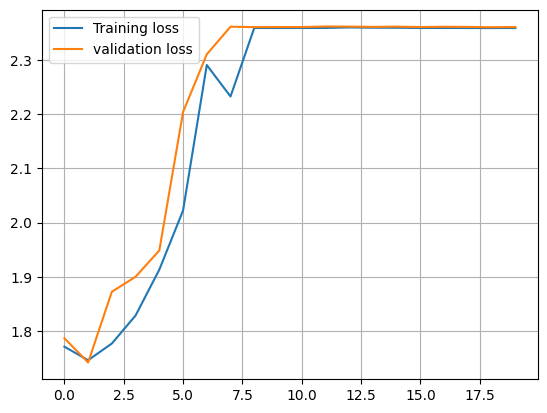

In [37]:
plt.plot(epochs_trian_loss, label="Training loss")
plt.plot(epochs_val_loss, label="validation loss")
plt.legend()
plt.grid(True)

In [38]:
Accuracy(model, validation_dl)

0.10031582446808511

In [39]:
model = mlp(img_wdth, num_channels, hid_dim, num_classes)
model.to(device)
model

mlp(
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=256, bias=True)
  (classifier): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (selu): SELU()
  (softmax): Softmax(dim=-1)
)

## Different types of learning rate scheduler

PyTorch provides various learning rate schedulers that can adjust the learning rate during training. Here are explanations of some commonly used learning rate schedulers in PyTorch:

1. `torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)`:
    - Adjusts the learning rate by a factor of `gamma` every `step_size` epochs.
    - Example:


In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

2. `torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up, step_size_down)`:
    - Implements a cyclical learning rate policy where the learning rate cyclically varies between `base_lr` and `max_lr`.
    - Example:


In [ ]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=2000, step_size_down=2000)

3. `torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False)`:
    - Reduces the learning rate when a metric has stopped improving.
    - Example:



In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

4. `torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0)`:
    - Sets the learning rate of each parameter group using a cosine annealing schedule.
    - Example


In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

5. `torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps, anneal_strategy='cos', cycle_momentum=True)`:
    - Sets the learning rate of each parameter group according to the 1cycle learning rate policy.
    - Example:


In [ ]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=1000)

Rest of code example

In [40]:
lr = 1e-2
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

- ReduceLROnPlateau

In [42]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4, patience=2, verbose=True)

In [43]:
model, epochs_trian_loss, epochs_val_loss = training(model, loss_module, optimizer, train_dl, validation_dl, num_epochs, device, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

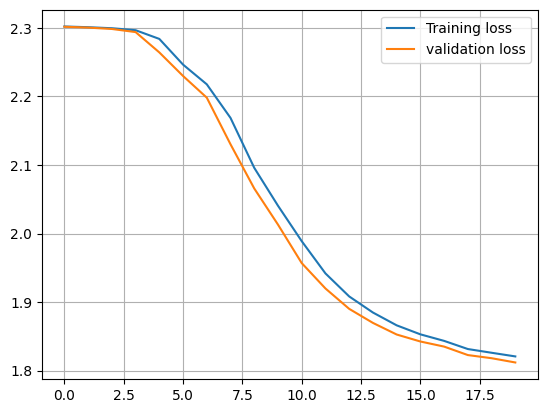

In [44]:
plt.plot(epochs_trian_loss, label="Training loss")
plt.plot(epochs_val_loss, label="validation loss")
plt.legend()
plt.grid(True)

In [45]:
Accuracy(model, validation_dl)

0.6624833776595744

### How to overcome overfitting? 
- early stopping
- regularization terms
- data augmentation
- etc

### What are L1 and L2 regularization ?

<img src="https://www.researchgate.net/profile/Nibaran-Das/publication/355020694/figure/fig2/AS:1106343318560770@1640784210609/Parameter-norm-penalties-L2-norm-regularization-left-and-L1-norm-regularization.ppm" alt="Regularization" width="700" height="300">

1. **L1 Regularization (Lasso Regularization)**:
    - L1 regularization, also known as Lasso regularization, adds a penalty term to the loss function that is proportional to the absolute value of the model's weights.
    - Mathematically, the L1 regularization term can be represented as: $$\lambda \sum_{i=1}^n |w_i|$$ where $\lambda$ is the regularization parameter, $w_i$ is the $i^{th}$ weight, and $n$ is the number of weights.
    - The L1 regularization term encourages sparse solutions, where some weights are set to zero. This can be useful for feature selection or reducing the complexity of the model.
2. **L2 Regularization (Ridge Regularization)**:
    - L2 regularization, also known as Ridge regularization, adds a penalty term to the loss function that is proportional to the square of the model's weights.
    - Mathematically, the L2 regularization term can be represented as: $$\lambda \sum_{i=1}^n w_i^2$$ where $\lambda$ is the regularization parameter, $w_i$ is the $i^{th}$ weight, and $n$ is the number of weights.
    - The L2 regularization term encourages small weights and can help prevent overfitting by reducing the magnitude of the weights.

In both L1 and L2 regularization, the regularization parameter $\lambda$ controls the strength of the regularization term. A larger value of $\lambda$ leads to stronger regularization and smaller weights.

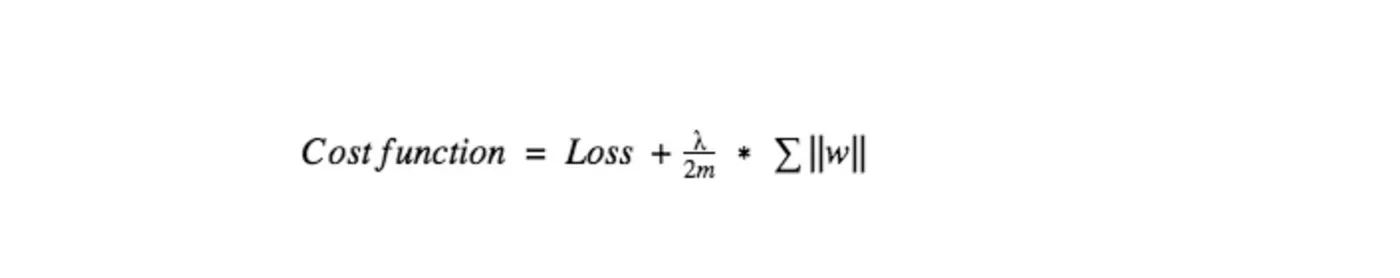

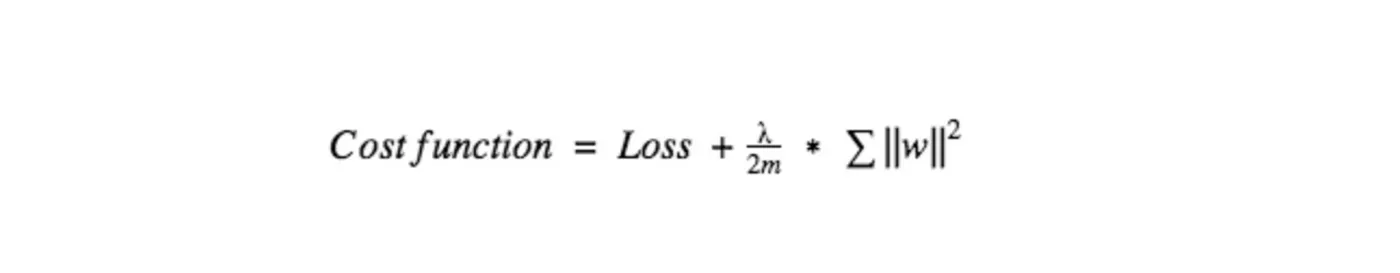

In [46]:
def training(model, loss_module, optimizer, train_dl, val_dl, num_epochs, device, lmbda, norm_type:int, scheduler=None):
    epochs_trian_loss = []
    epochs_val_loss = []

    pbar = tqdm(range(num_epochs))
    for _ in pbar:
        #Defining the mode of the model (if its validation mode it doesnt calculate the gradient)
        model.train()
        avgLoss = 0
        for x, y in train_dl:
            # transfering images and their labels to the gpu memory 
            x = x.to(device) 
            y = y.to(device)

            y_ht = model(x)
            
            loss = loss_module(y_ht, y)

            l1_loss = torch.tensor(0., device=device)
            for param in model.parameters():
                l1_loss += torch.norm(param, norm_type)
            loss += lmbda * l1_loss

            # Set preciously calculated gradients to zero for everysingle parameter
            optimizer.zero_grad()
            # Back propagate the gradient through the network and free the outputs of each layer
            loss.backward()
            # Update parameters 
            optimizer.step()

            avgLoss += loss.item()

        avgLoss /= len(train_dl)

        if scheduler:
            scheduler.step(avgLoss)
            
        epochs_trian_loss.append(avgLoss)
        epochs_val_loss.append(evaluation(model, loss_module, val_dl, device))
        pbar.set_description(f"Loss is : [{avgLoss}]")
        
    return model, epochs_trian_loss, epochs_val_loss

In [47]:
model = mlp(img_wdth, num_channels, hid_dim, num_classes)
model.to(device)
model

mlp(
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=256, bias=True)
  (classifier): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (selu): SELU()
  (softmax): Softmax(dim=-1)
)

In [48]:
lr = 1e-3
num_epochs = 50
norm_type = 2
lmbda = 0.005
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [50]:
model, epochs_trian_loss, epochs_val_loss = training(model, loss_module, optimizer, train_dl, validation_dl, num_epochs, device, lmbda, norm_type)

  0%|          | 0/50 [00:00<?, ?it/s]

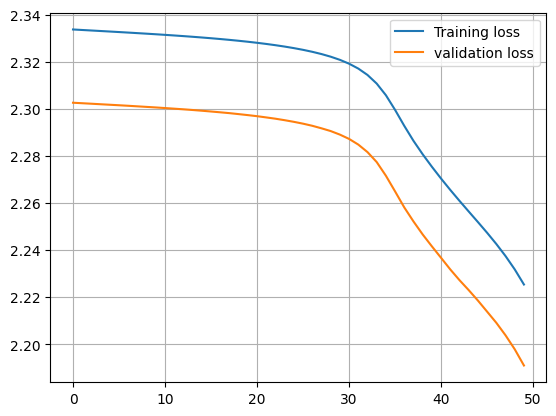

In [53]:
plt.plot(epochs_trian_loss, label="Training loss")
plt.plot(epochs_val_loss, label="validation loss")
plt.legend()
plt.grid(True)

In [52]:
Accuracy(model, validation_dl)

0.47647938829787234

### Early Stopping

Early stopping is a technique used in machine learning to prevent overfitting by stopping the training process when the performance of the model on a validation set stops improving. It is a common approach in supervised learning tasks where the model is trained for a fixed number of epochs.

Here's an explanation of how early stopping can be implemented in PyTorch:


1. Define the Early Stopping Criterion:
    - Determine the validation metric that you want to monitor, such as accuracy, loss, or any other relevant metric.
    - Set a threshold for improvement in the validation metric. For example, if the validation metric is increasing, you can set a threshold to stop training when the validation metric stops improving for a certain number of consecutive epochs.
2. Initialize Variables:
    - Initialize a variable to keep track of the best validation metric value encountered so far.

In [18]:
def training(model, loss_module, optimizer, train_dl, val_dl, num_epochs, device, early_trs, scheduler=None):
    epochs_trian_loss = []
    epochs_val_loss = []

    counter = 0
    best_loss = 100000
    best_model = deepcopy(model)

    pbar = tqdm(range(num_epochs))
    for _ in pbar:
        #Defining the mode of the model (if its validation mode it doesnt calculate the gradient)
        model.train()
        avgLoss = 0
        for x, y in train_dl:
            # transfering images and their labels to the gpu memory 
            x = x.to(device) 
            y = y.to(device)

            y_ht = model(x)
            
            loss = loss_module(y_ht, y)

            # Set preciously calculated gradients to zero for everysingle parameter
            optimizer.zero_grad()
            # Back propagate the gradient through the network and free the outputs of each layer
            loss.backward()
            # Update parameters 
            optimizer.step()

            avgLoss += loss.item()

        avgLoss /= len(train_dl)
        if scheduler:
            scheduler.step(avgLoss)
        epochs_trian_loss.append(avgLoss)
        epochs_val_loss.append(evaluation(model, loss_module, val_dl, device))

        #Early stopping part 
        if epochs_val_loss[-1] <= best_loss:
            best_loss = epochs_val_loss[-1]
            counter = 0
            best_model = deepcopy(model)
        else :
            counter += 1
            if counter % early_trs == 0:
                break
            
        
        pbar.set_description(f"Loss is : [{avgLoss}]")
        
    return best_model, epochs_trian_loss, epochs_val_loss

In [27]:
model = mlp(img_wdth, num_channels, hid_dim, num_classes)
model.to(device)
model

mlp(
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=256, bias=True)
  (classifier): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (selu): SELU()
  (softmax): Softmax(dim=-1)
)

In [28]:
threshhold = 3
lr = 1e-2

loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [29]:
model, epochs_trian_loss, epochs_val_loss = training(model, loss_module, optimizer, train_dl, validation_dl, num_epochs, device, threshhold)

  0%|          | 0/20 [00:00<?, ?it/s]

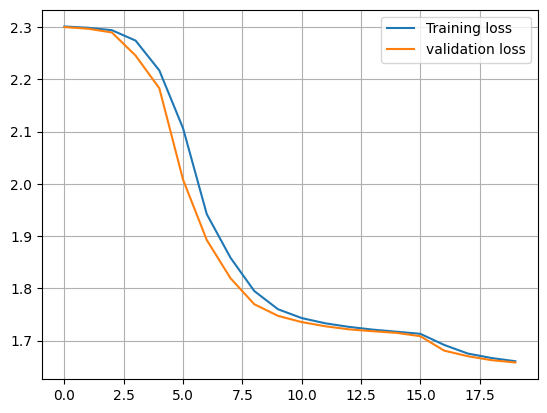

In [30]:
plt.plot(epochs_trian_loss, label="Training loss")
plt.plot(epochs_val_loss, label="validation loss")
plt.legend()
plt.grid(True)

In [31]:
Accuracy(model, validation_dl)

0.816156914893617